## Time Series Analysis

### Agenda
   
    ♦ Problem Description
    ♦ Data Understanding
    ♦ Basic data Pre-processing
    ♦ Time-Series related Pre-processing
    ♦ Time-Series Data Aggregation 
    ♦ Data split: train and validation sets
    ♦ Creating Time-Series Object
    ♦ Moving Averages

## Problem Statement

A multinational e-commerce company idenified a segment of products which are showing less sales when comapred to other class of products. As the prices of those products are volatile periodically based on demand and other economic factors, if they quote right price on time then the chance of incrasing sales is very high. They want to understand what is right price to quote on a given period for each product which will help them to increase the sales. The given data contains historical data of a product. Perform time series analysis and forecast the price.

In [1]:
library(zoo) # Z's Ordered Observations

library(dplyr)
library(TTR) # Technical Trading Rules
library(forecast)
library(DMwR)
library(tseries)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: lattice

Loading required package: grid



In [2]:
options(repr.plot.width = 20, repr.plot.height = 10)

## Data Understanding

In [3]:
## Load the .rds file into R

#data = readRDS("/home/datasets/lab/Data.rds")
data = readRDS("/home/datasets/lab/course_06/Data.rds")

In [4]:
## Dimension of the Data set
dim(data)

[1] 19657     3

In [5]:
## Structure of the Data set
str(data)

Classes ‘data.table’ and 'data.frame':	19657 obs. of  3 variables:
 $ SKU  : num  1 2 3 1 2 2 2 1 1 2 ...
 $ Price: num  130 58 84.4 160 57 ...
 $ Date : chr  "2009-06-01" "2009-06-01" "2009-12-08" "2009-12-08" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [6]:
## Look at the summary statistics
summary(data)

      SKU            Price            Date          
 Min.   :1.000   Min.   : 20.27   Length:19657      
 1st Qu.:1.000   1st Qu.: 50.15   Class :character  
 Median :2.000   Median : 70.97   Mode  :character  
 Mean   :1.942   Mean   : 80.63                     
 3rd Qu.:3.000   3rd Qu.:105.00                     
 Max.   :3.000   Max.   :999.00                     

In [7]:
# Look at the first and last 6 records using head and tail commands

head(data, 6)

,SKU,Price,Date
,<dbl>,<dbl>,<chr>
1,1,129.98,2009-06-01
2,2,57.96,2009-06-01
3,3,84.38,2009-12-08
4,1,159.96,2009-12-08
5,2,56.98,2009-12-08
6,2,58.38,2009-12-08


In [8]:
tail(data, 6)

SKU,Price,Date
<dbl>,<dbl>,<chr>
3,79.62,2013-08-09
2,39.68,2013-08-09
3,78.00,2013-08-09
3,79.62,2013-08-09
3,79.62,2013-08-09
2,38.99,2013-08-09


In [9]:
# Get the unique levels and their counts in SKU attribute
table(data$SKU)


   1    2    3 
6997 6812 5848 

## Basic Pre-processing

In [10]:
# Convert attributes into appropriate type
data$SKU = as.factor(data$SKU)

data$Date = as.Date(data$Date, format="%Y-%m-%d")

# Re-look at the first 6 records
head(data)

SKU,Price,Date
<fct>,<dbl>,<date>
1,129.98,2009-06-01
2,57.96,2009-06-01
3,84.38,2009-12-08
1,159.96,2009-12-08
2,56.98,2009-12-08
2,58.38,2009-12-08


In [11]:
# Summary of the data
summary(data)

 SKU          Price             Date           
 1:6997   Min.   : 20.27   Min.   :2009-03-06  
 2:6812   1st Qu.: 50.15   1st Qu.:2010-10-22  
 3:5848   Median : 70.97   Median :2011-11-06  
          Mean   : 80.63   Mean   :2011-10-25  
          3rd Qu.:105.00   3rd Qu.:2012-11-26  
          Max.   :999.00   Max.   :2013-12-02  

#### Drop rows where Price is 999

In [12]:
## Check the number of rows where Price is 999 

data[data$Price == 999 ,]

SKU,Price,Date
<fct>,<dbl>,<date>
3,999,2010-08-24


In [13]:
## Drop the row where Price is 999

data = data[data$Price != 999 ,]

In [14]:
## Check summary after dropping the row

summary(data)

 SKU          Price             Date           
 1:6997   Min.   : 20.27   Min.   :2009-03-06  
 2:6812   1st Qu.: 50.15   1st Qu.:2010-10-22  
 3:5847   Median : 70.96   Median :2011-11-06  
          Mean   : 80.58   Mean   :2011-10-25  
          3rd Qu.:105.00   3rd Qu.:2012-11-26  
          Max.   :487.72   Max.   :2013-12-02  

## Time-Series related Pre-processing

In [15]:
# Focusing on a particular product of choice (Let's use only SKU code 3 for analysis)
data = data[data$SKU==3,]
# Basic info about that product
dim(data)
summary(data)
head(data)

[1] 5847    3

 SKU          Price             Date           
 1:   0   Min.   : 39.84   Min.   :2009-04-15  
 2:   0   1st Qu.: 60.00   1st Qu.:2011-01-26  
 3:5847   Median : 72.25   Median :2012-03-01  
          Mean   : 73.14   Mean   :2011-12-31  
          3rd Qu.: 83.75   3rd Qu.:2013-01-08  
          Max.   :379.80   Max.   :2013-12-02  

SKU,Price,Date
<fct>,<dbl>,<date>
3,84.38,2009-12-08
3,115.98,2009-06-01
3,115.98,2009-06-02
3,84.38,2009-12-09
3,115.98,2009-06-03
3,84.38,2009-12-10


In [16]:
# As all records has same SKU, it can be removed
data$SKU = NULL
head(data)

# Sort the Data in increasing order of date
data = data[order(data$Date, decreasing=F), ]
head(data)

Price,Date
<dbl>,<date>
84.38,2009-12-08
115.98,2009-06-01
115.98,2009-06-02
84.38,2009-12-09
115.98,2009-06-03
84.38,2009-12-10


Price,Date
<dbl>,<date>
58.65,2009-04-15
79.64,2009-04-16
58.65,2009-04-16
79.64,2009-04-17
58.65,2009-04-17
79.64,2009-04-18


In [17]:
# Handle Duplicates
# On the given date, product has multiple prices, so one way is to consider the min price.
# Use dplyr package to do the same.
#library(dplyr)

data = data %>% group_by(Date) %>% summarise("MinPrice" = min(Price))
data = data.frame(data)
head(data)

,Date,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-05-30,115.98
6,2009-05-31,115.98


In [18]:
# Handle missing values 
minDate = min(data$Date)
maxDate = max(data$Date)

minDate
maxDate

[1] "2009-04-15"

[1] "2013-12-02"

In [19]:
seq = data.frame("DateRange" = seq(minDate, maxDate, by="days"))

data = seq %>% full_join(data, c("DateRange" = "Date"))
data = data.frame(data)

rm(minDate, maxDate, seq)
head(data,10)

,DateRange,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-04-19,NA
6,2009-04-20,NA
7,2009-04-21,NA
8,2009-04-22,NA
9,2009-04-23,NA


In [20]:
# Imputation of Missing Values
data$MinPrice = (na.locf(data$MinPrice, fromLast = FALSE) + 
                   na.locf(data$MinPrice, fromLast = TRUE))/2

head(data)

,DateRange,MinPrice
,<date>,<dbl>
1,2009-04-15,58.65
2,2009-04-16,58.65
3,2009-04-17,58.65
4,2009-04-18,79.64
5,2009-04-19,97.81
6,2009-04-20,97.81


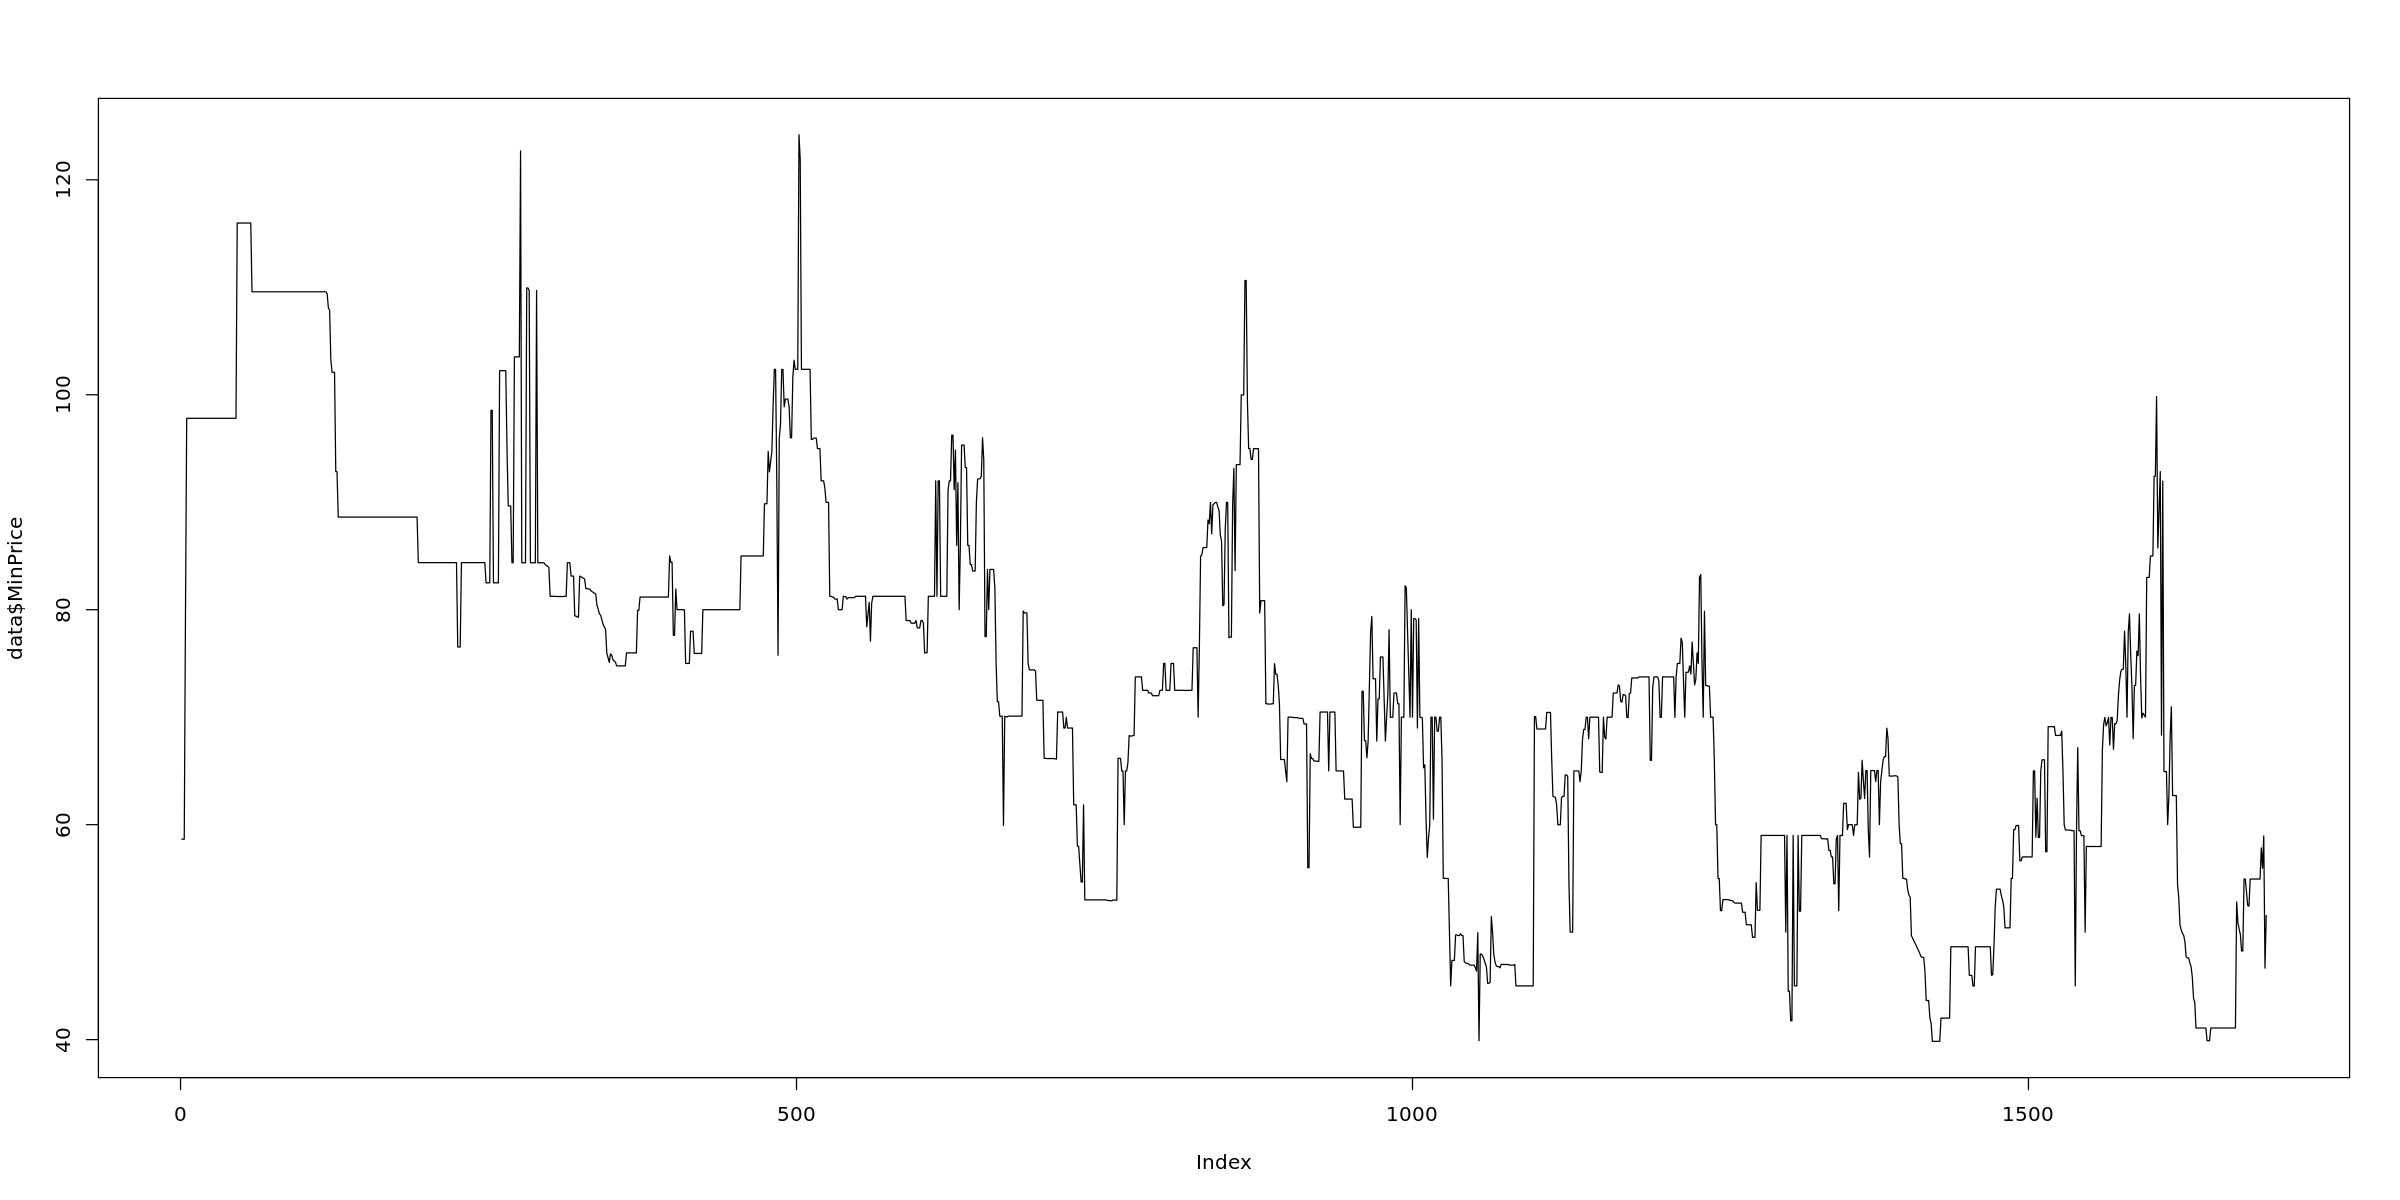

In [21]:
plot(data$MinPrice, type = 'l')

#### Demo of "na.locf()"  function

In [22]:
# Here is the example to understand how "na.locf()"  function works
#library(zoo)
x <- c(1,2,3,4,5,NA,NA,NA,7,8)
x

[1]  1  2  3  4  5 NA NA NA  7  8

In [23]:
# na.locf function is used to replace the missing values. 
# This will replace the missing value with the it's immediate preceding value. 
na.locf(x,fromLast = FALSE)

[1] 1 2 3 4 5 5 5 5 7 8

In [24]:
# When we use the argument fromLast = TRUE , it replace the missing value with the it's immediate succeding value
na.locf(x,fromLast = TRUE,na.rm = FALSE)

[1] 1 2 3 4 5 7 7 7 7 8

In [25]:
# if you want to replace the missing value with average value of it's immediate neighbors, here is the R code. 
#This code is to show that missing value is replaced with it's preceding and succeeding values
na.locf(x,fromLast = FALSE)
na.locf(x,fromLast = TRUE)

(na.locf(x, fromLast = FALSE) + na.locf(x, fromLast = TRUE))/2

rm(x)

[1] 1 2 3 4 5 5 5 5 7 8

[1] 1 2 3 4 5 7 7 7 7 8

[1] 1 2 3 4 5 6 6 6 7 8

## Time-Series Data Aggregation 

In [26]:
# Aggregate Data at month level from day level
# Derive Year and Month attribute 
data$Year = as.numeric(format(data$DateRange, format="%Y"))
data$Month = as.numeric(format(data$DateRange, format="%m"))
head(data)

,DateRange,MinPrice,Year,Month
,<date>,<dbl>,<dbl>,<dbl>
1,2009-04-15,58.65,2009,4
2,2009-04-16,58.65,2009,4
3,2009-04-17,58.65,2009,4
4,2009-04-18,79.64,2009,4
5,2009-04-19,97.81,2009,4
6,2009-04-20,97.81,2009,4


In [27]:
data = data %>% group_by(Year, Month) %>% summarise("MeanPrice" = mean(MinPrice))

head(data)

`summarise()` has grouped output by 'Year'. You can override using the `.groups` argument.



Year,Month,MeanPrice
<dbl>,<dbl>,<dbl>
2009,4,89.33187
2009,5,98.98226
2009,6,111.71333
2009,7,109.58000
2009,8,99.34645
2009,9,88.61500


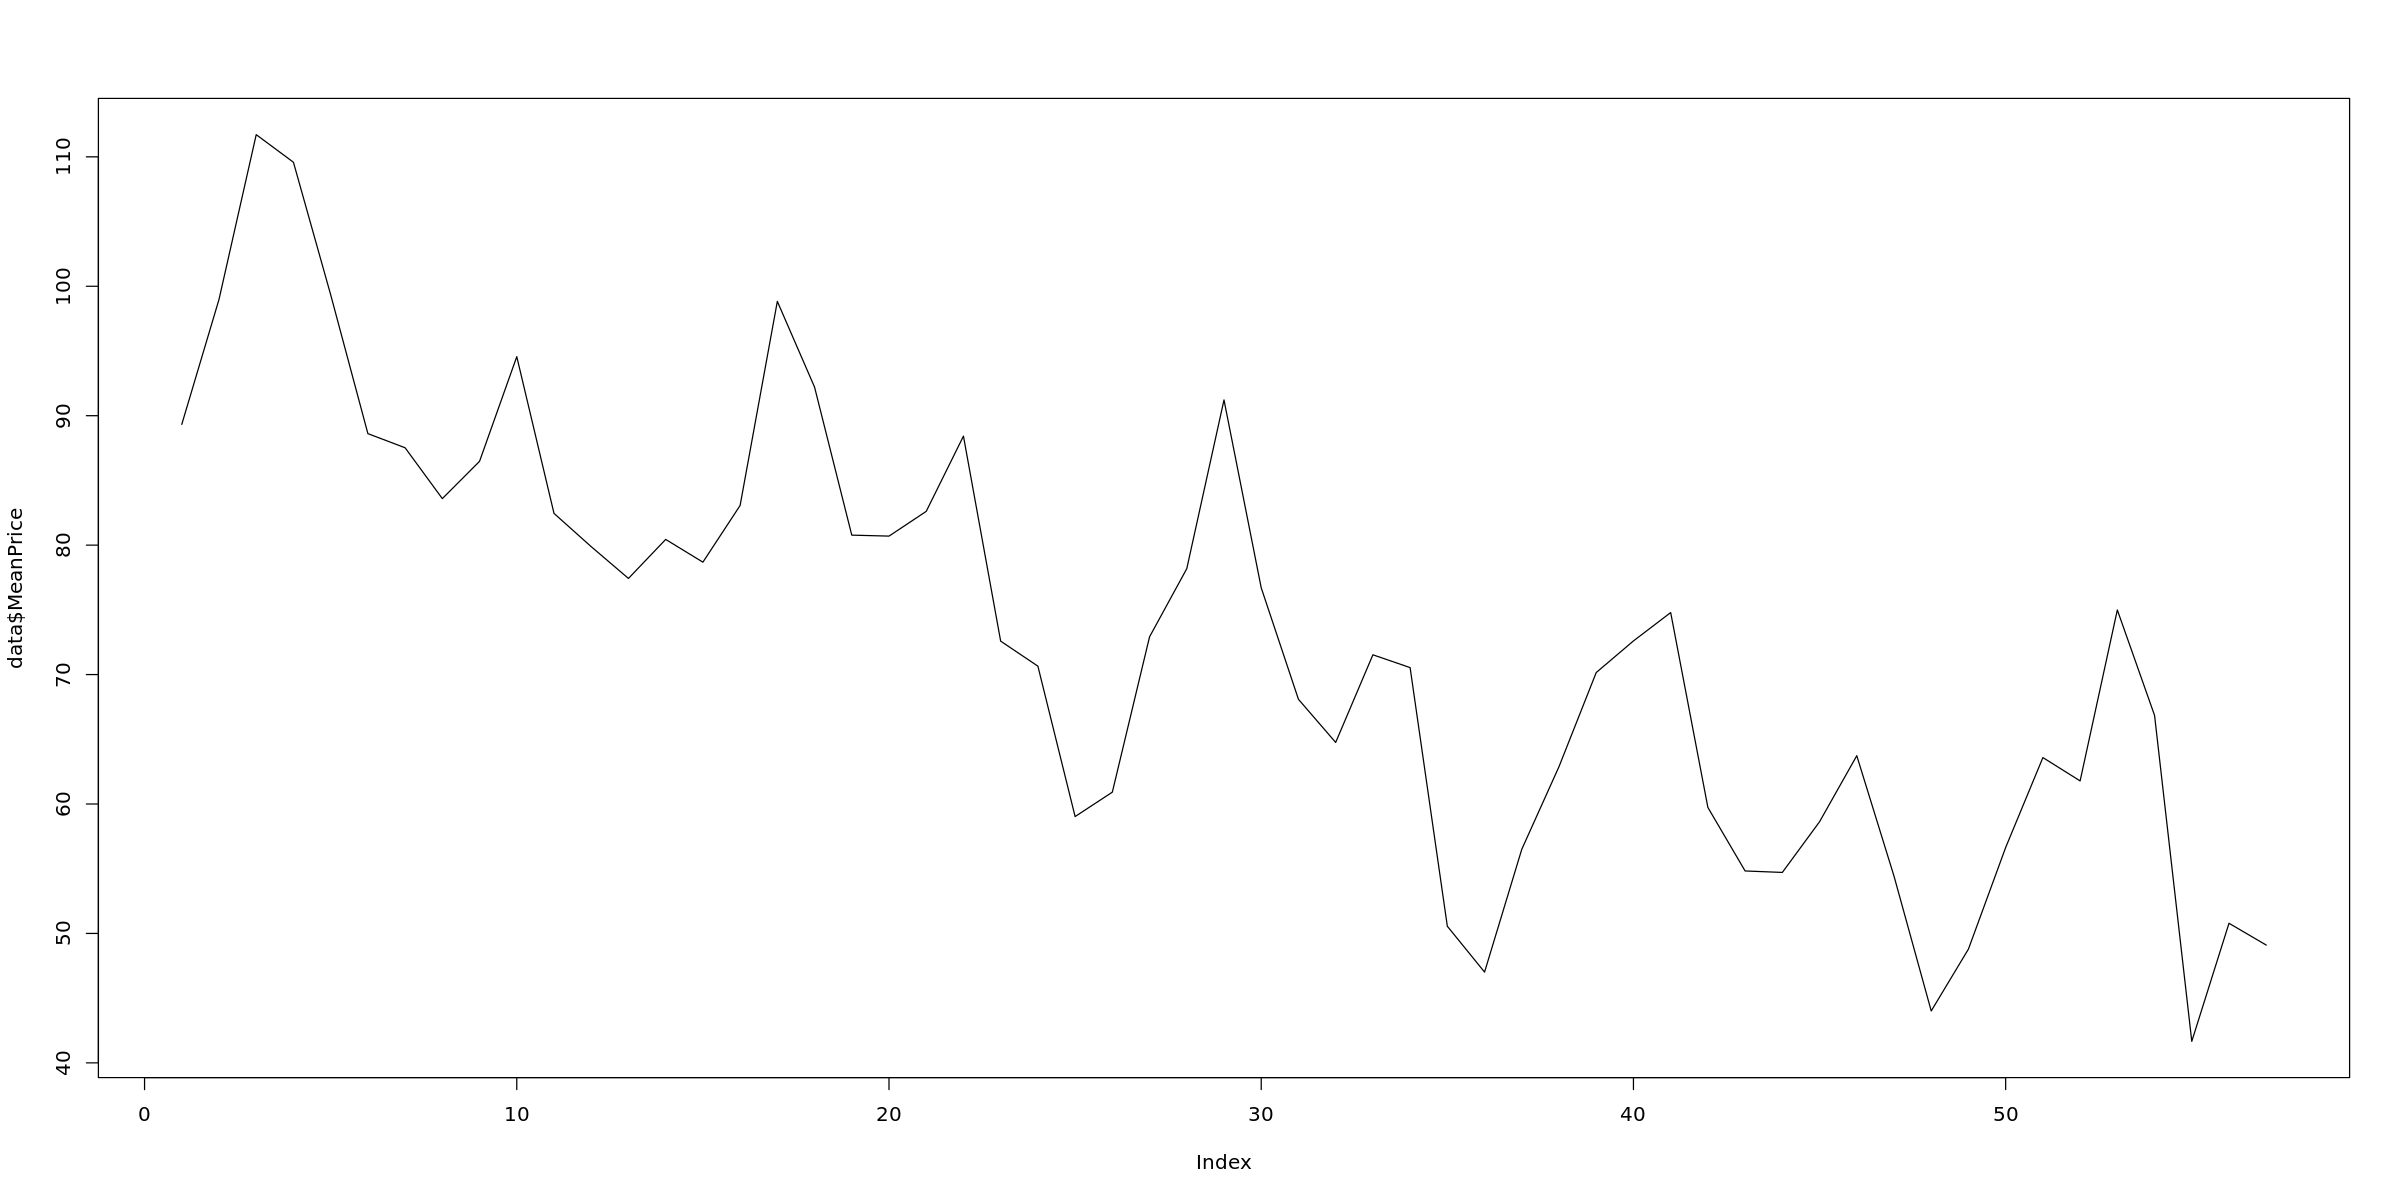

In [28]:
data = data.frame(data)
plot(data$MeanPrice, type = 'l')

In [29]:
# Creating sequence Time variable.
data$Time = 1:nrow(data)
# Month attribute is used in future model for seasonality 
data$Month = as.factor(data$Month)

# Year attribute is not required further, so removing it
data$Year = NULL

head(data)

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
1,4,89.33187,1
2,5,98.98226,2
3,6,111.71333,3
4,7,109.58000,4
5,8,99.34645,5
6,9,88.61500,6


## Data split: train and validation sets

In [30]:
# Splitting the Dataset into Train and Test
train = data[1:53,]
val = data[54:nrow(data),]
#rm(data)

In [31]:
train

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
1,4,89.33187,1
2,5,98.98226,2
3,6,111.71333,3
4,7,109.58000,4
5,8,99.34645,5
6,9,88.61500,6
7,10,87.52210,7
8,11,83.59500,8
9,12,86.47677,9


In [32]:
val

,Month,MeanPrice,Time
,<fct>,<dbl>,<int>
54,9,66.84800,54
55,10,41.66387,55
56,11,50.78450,56
57,12,49.10000,57


## Regression on Time

In [33]:
# Simple Linear Regression
lm1 = lm(MeanPrice~Time, data = train)
summary(lm1)


Call:
lm(formula = MeanPrice ~ Time, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.834  -5.766  -1.474   5.825  22.394 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 97.02243    2.61063  37.164  < 2e-16 ***
Time        -0.83822    0.08413  -9.964 1.46e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.369 on 51 degrees of freedom
Multiple R-squared:  0.6606,	Adjusted R-squared:  0.654 
F-statistic: 99.28 on 1 and 51 DF,  p-value: 1.459e-13


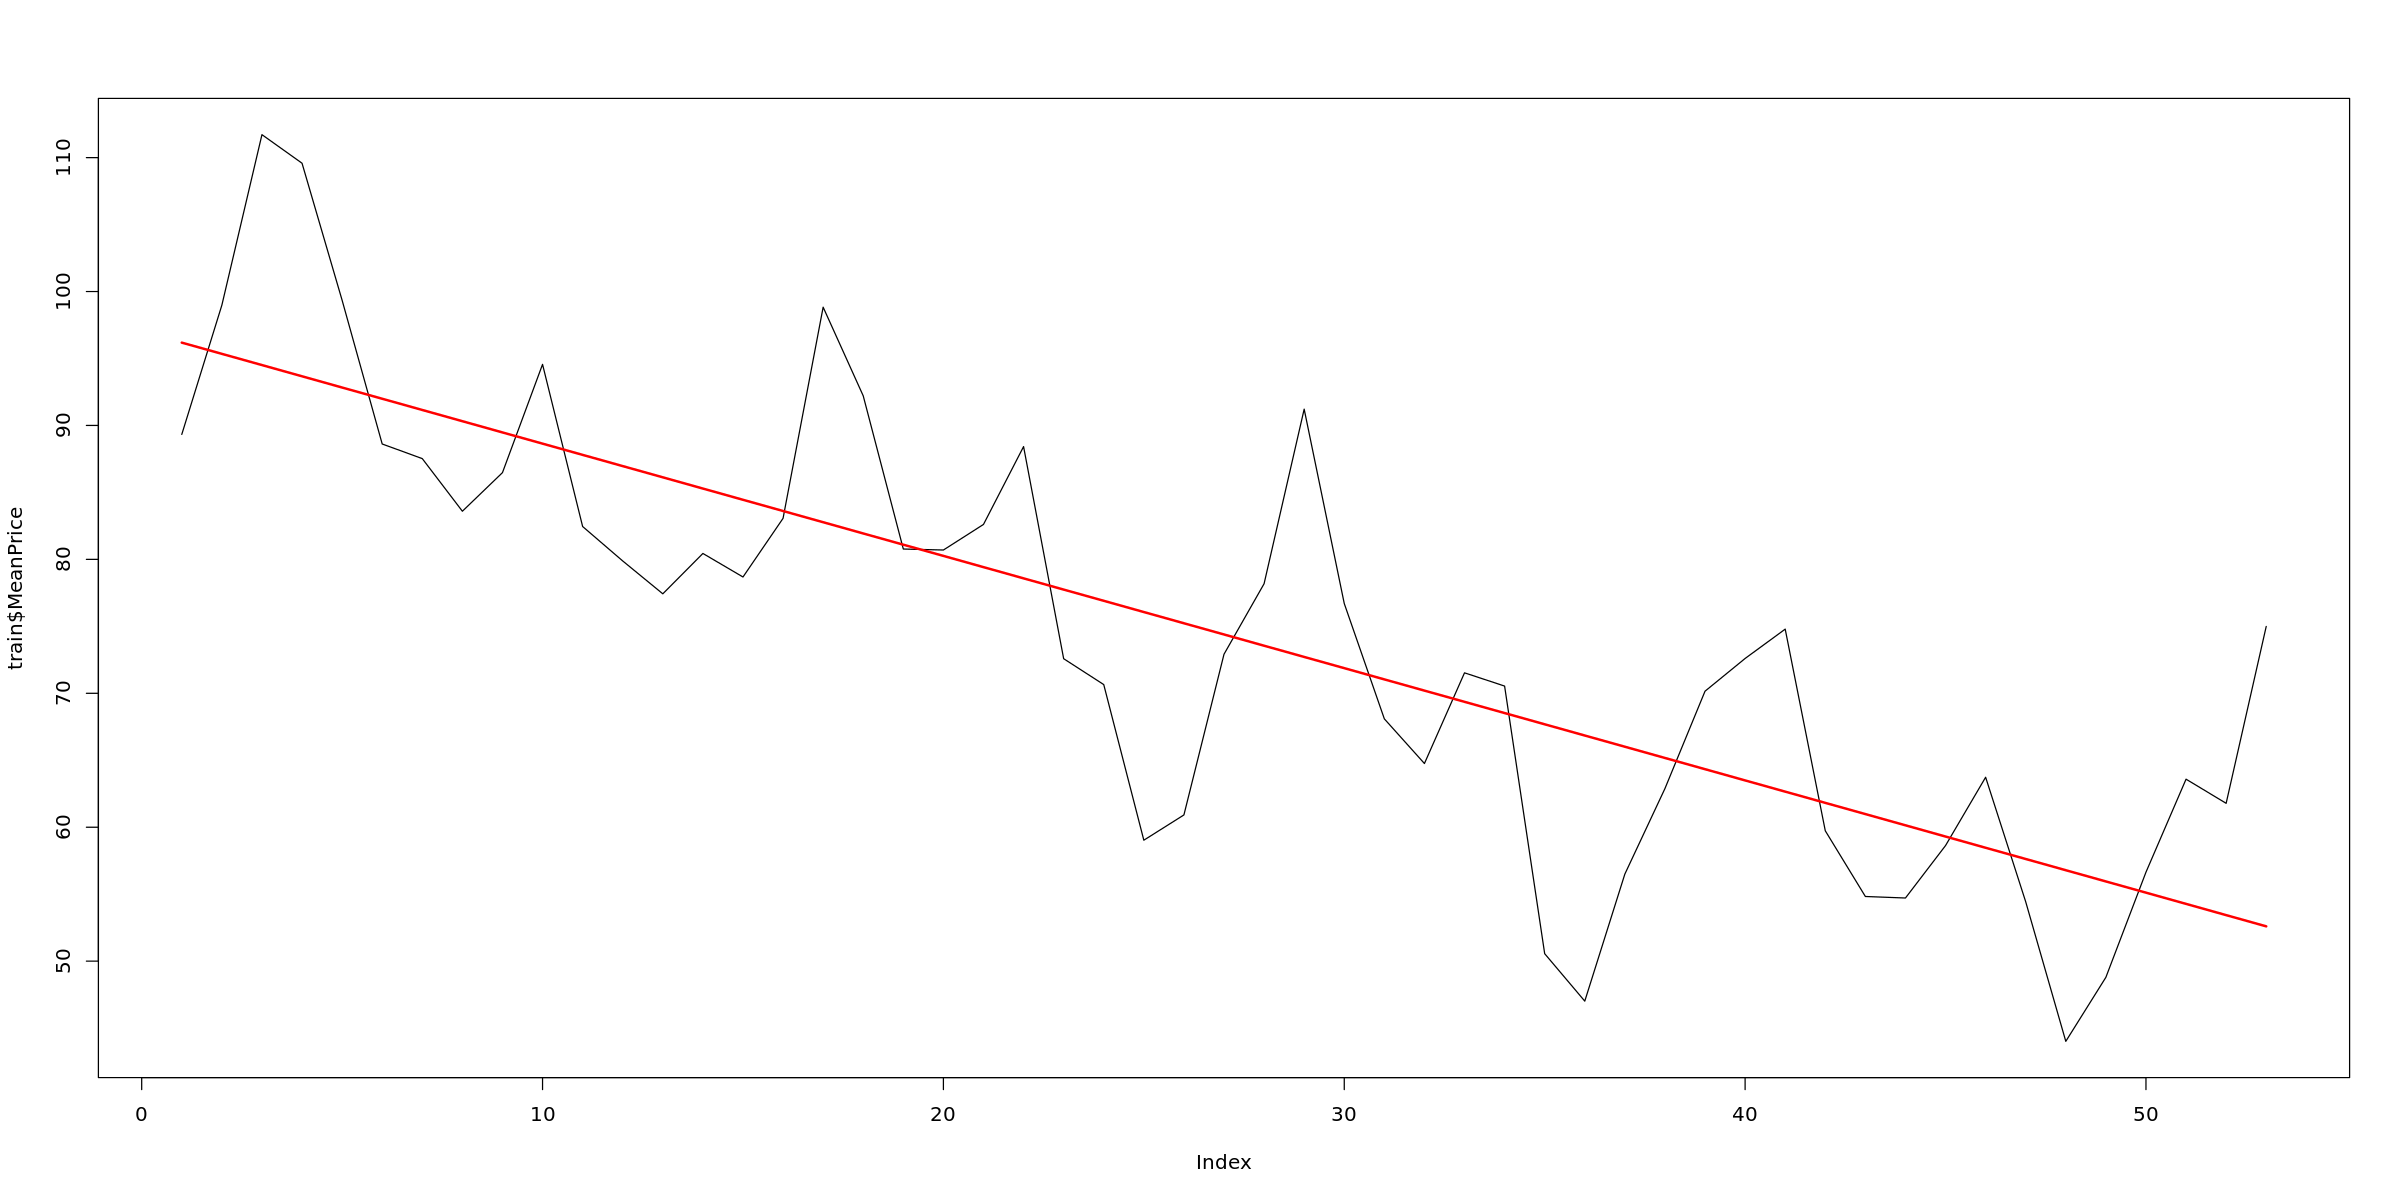

In [34]:
# get predictions on train and validation 
pred_Train = predict(lm1)
pred_Val  = predict(lm1, val)

# plot the train data along with predictions
plot(train$MeanPrice, type="l")
lines(train$Time, pred_Train, col="red", lwd=2)

In [35]:
# Evaluate model performance
lm1TrainError = regr.eval(train$MeanPrice, pred_Train)
lm1ValError  = regr.eval(val$MeanPrice, pred_Val)
lm1TrainError
lm1ValError

mae        mse       rmse       mape 
 7.3604306 84.4599186  9.1902078  0.1050726

mae        mse       rmse       mape 
 6.2980475 78.4718183  8.8584320  0.1161648

In [36]:
# Linear Regression Model using Month Variable (to capture Seasonality)
str(train)
slm1 <- lm(MeanPrice~., data=train)
summary(slm1)

'data.frame':	53 obs. of  3 variables:
 $ Month    : Factor w/ 12 levels "1","2","3","4",..: 4 5 6 7 8 9 10 11 12 1 ...
 $ MeanPrice: num  89.3 99 111.7 109.6 99.3 ...
 $ Time     : int  1 2 3 4 5 6 7 8 9 10 ...



Call:
lm(formula = MeanPrice ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.0569  -2.8466   0.7989   2.9696  11.9076 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 103.10638    3.25374  31.689  < 2e-16 ***
Month2      -13.45867    4.10584  -3.278 0.002168 ** 
Month3      -17.22491    4.10684  -4.194 0.000147 ***
Month4      -15.64557    3.89800  -4.014 0.000255 ***
Month5       -9.03884    3.89623  -2.320 0.025534 *  
Month6       -0.75135    3.89517  -0.193 0.848020    
Month7        1.72902    3.89482   0.444 0.659488    
Month8        9.37220    3.89517   2.406 0.020836 *  
Month9       -3.39729    4.11086  -0.826 0.413470    
Month10      -9.05949    4.10852  -2.205 0.033262 *  
Month11     -10.07176    4.10684  -2.452 0.018648 *  
Month12      -5.35198    4.10584  -1.304 0.199855    
Time         -0.84976    0.05248 -16.192  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual

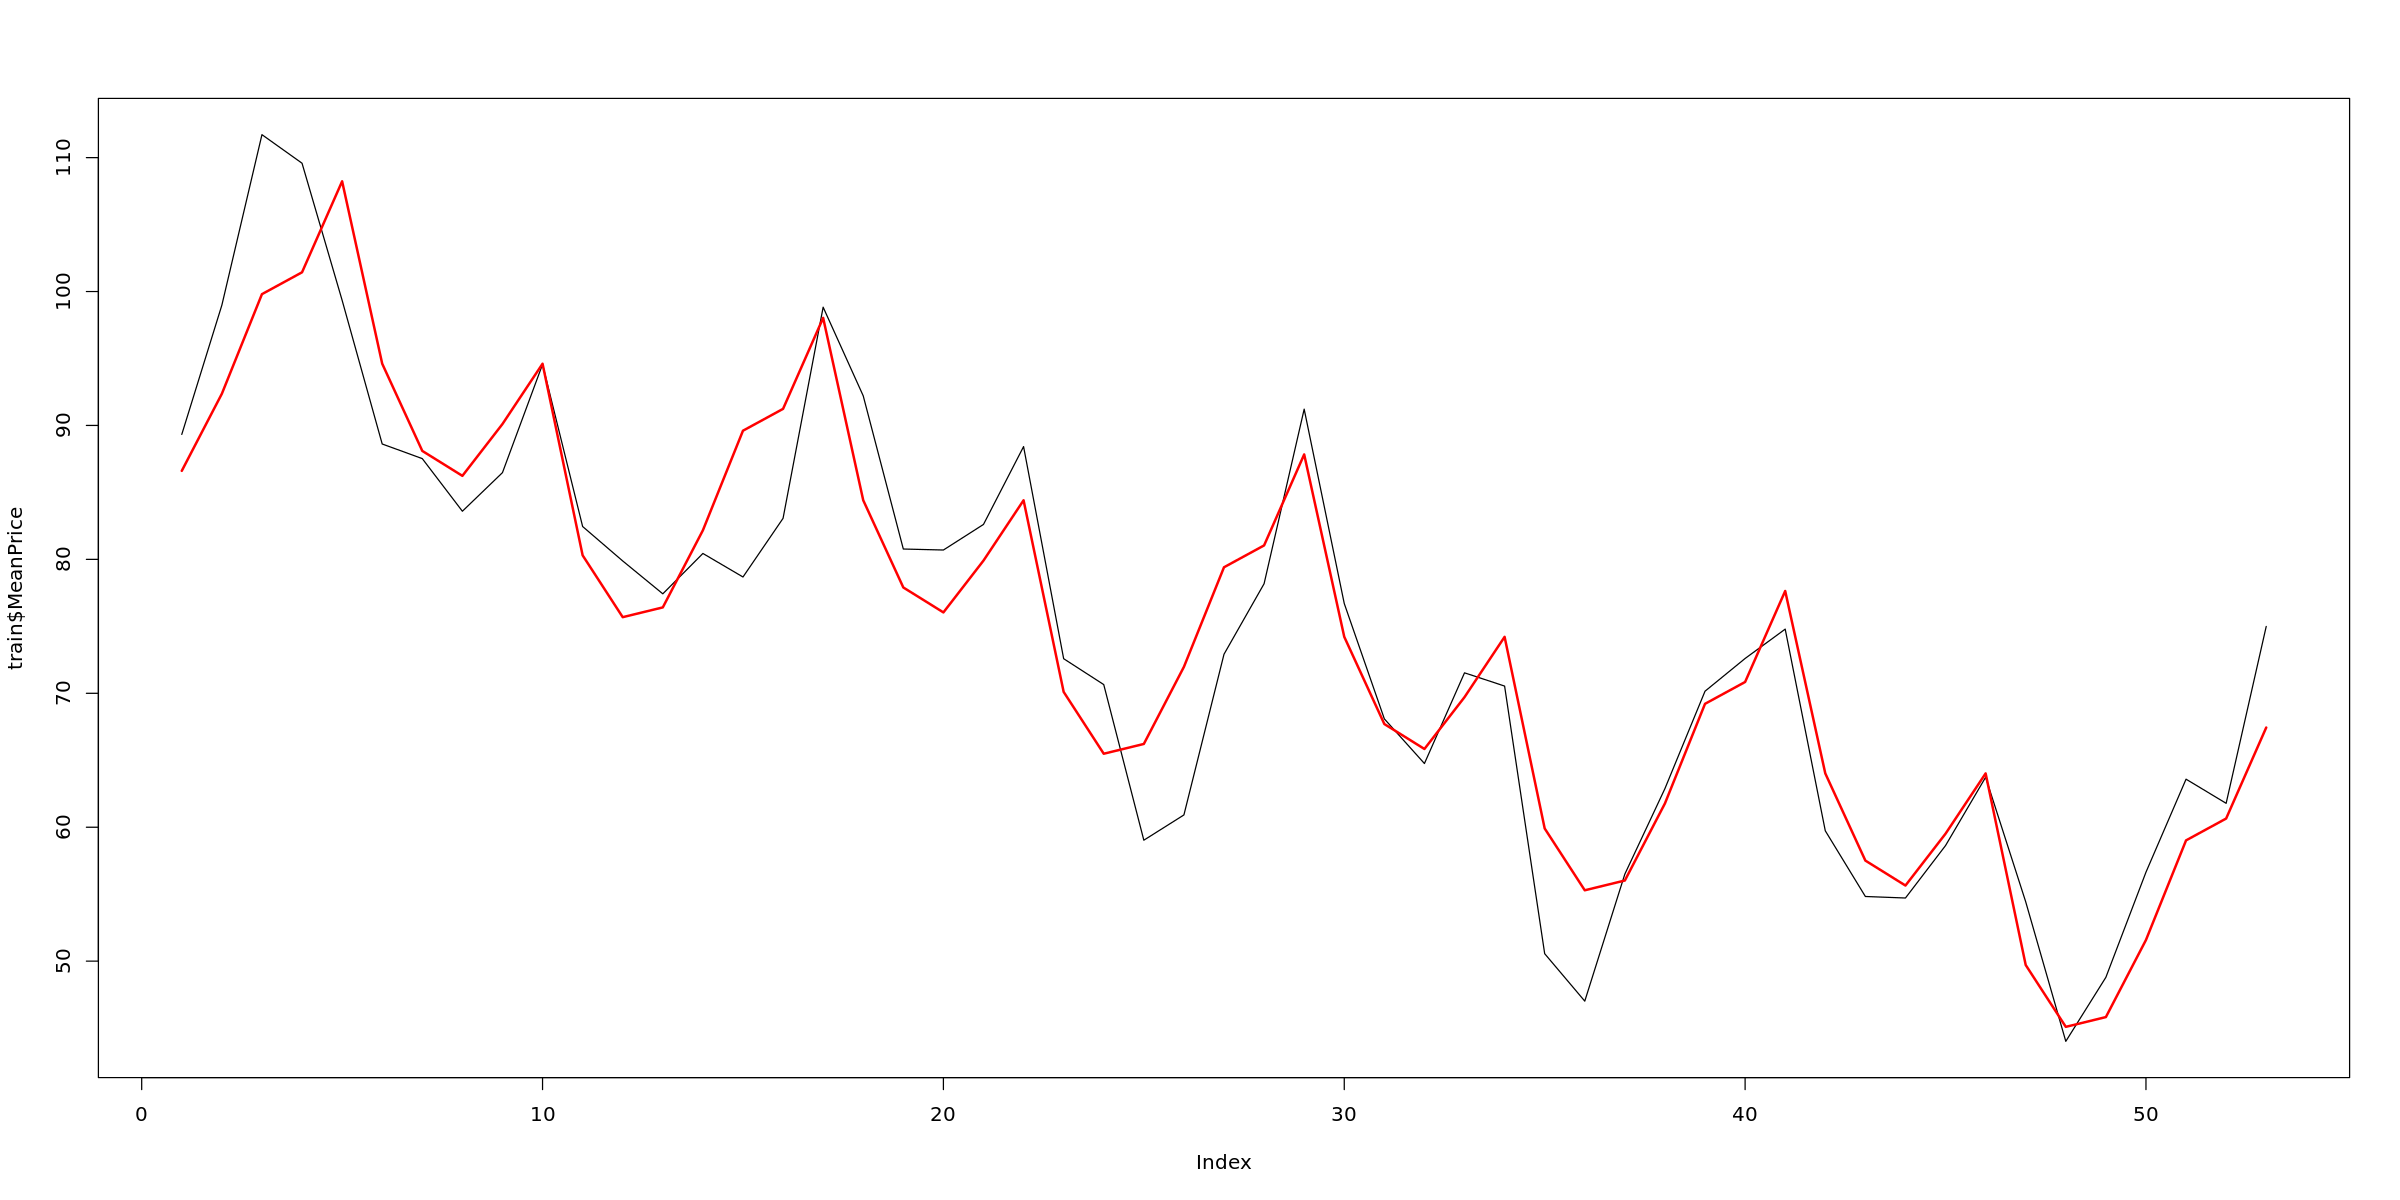

In [37]:
# get predictions on train and test
pred_Train = predict(slm1)
pred_Val  = predict(slm1, val)

# plot the train data along with predictions
plot(train$MeanPrice, type="l")
points(train$Time, pred_Train, type="l", col="red", lwd=2)

In [38]:
# Evaluate model performance
slm1TrainError = regr.eval(train$MeanPrice, pred_Train)
slm1ValError = regr.eval(val$MeanPrice, pred_Val)
slm1TrainError
slm1ValError

mae         mse        rmse        mape 
 3.98447730 25.44172377  5.04397896  0.05487652

mae        mse       rmse       mape 
 6.0566694 57.5215150  7.5842940  0.1099742

## Creating Time-Series Object

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2009,,,,89.33187,98.98226,111.71333,109.58000,99.34645,88.61500,87.52210,83.59500,86.47677
2010,94.56161,82.45250,79.88065,77.42767,80.44161,78.68367,83.06452,98.83145,92.20900,80.77274,80.69867,82.61000
2011,88.42161,72.58196,70.64968,59.03067,60.91677,72.91667,78.18194,91.21645,76.70200,68.08935,64.75600,71.52661
2012,70.53839,50.55517,47.01290,56.50133,62.88645,70.15700,72.60000,74.79161,59.73300,54.82694,54.71333,58.62968
2013,63.73032,54.42857,44.01097,48.79200,56.64129,63.58633,61.78355,74.99113,,,,


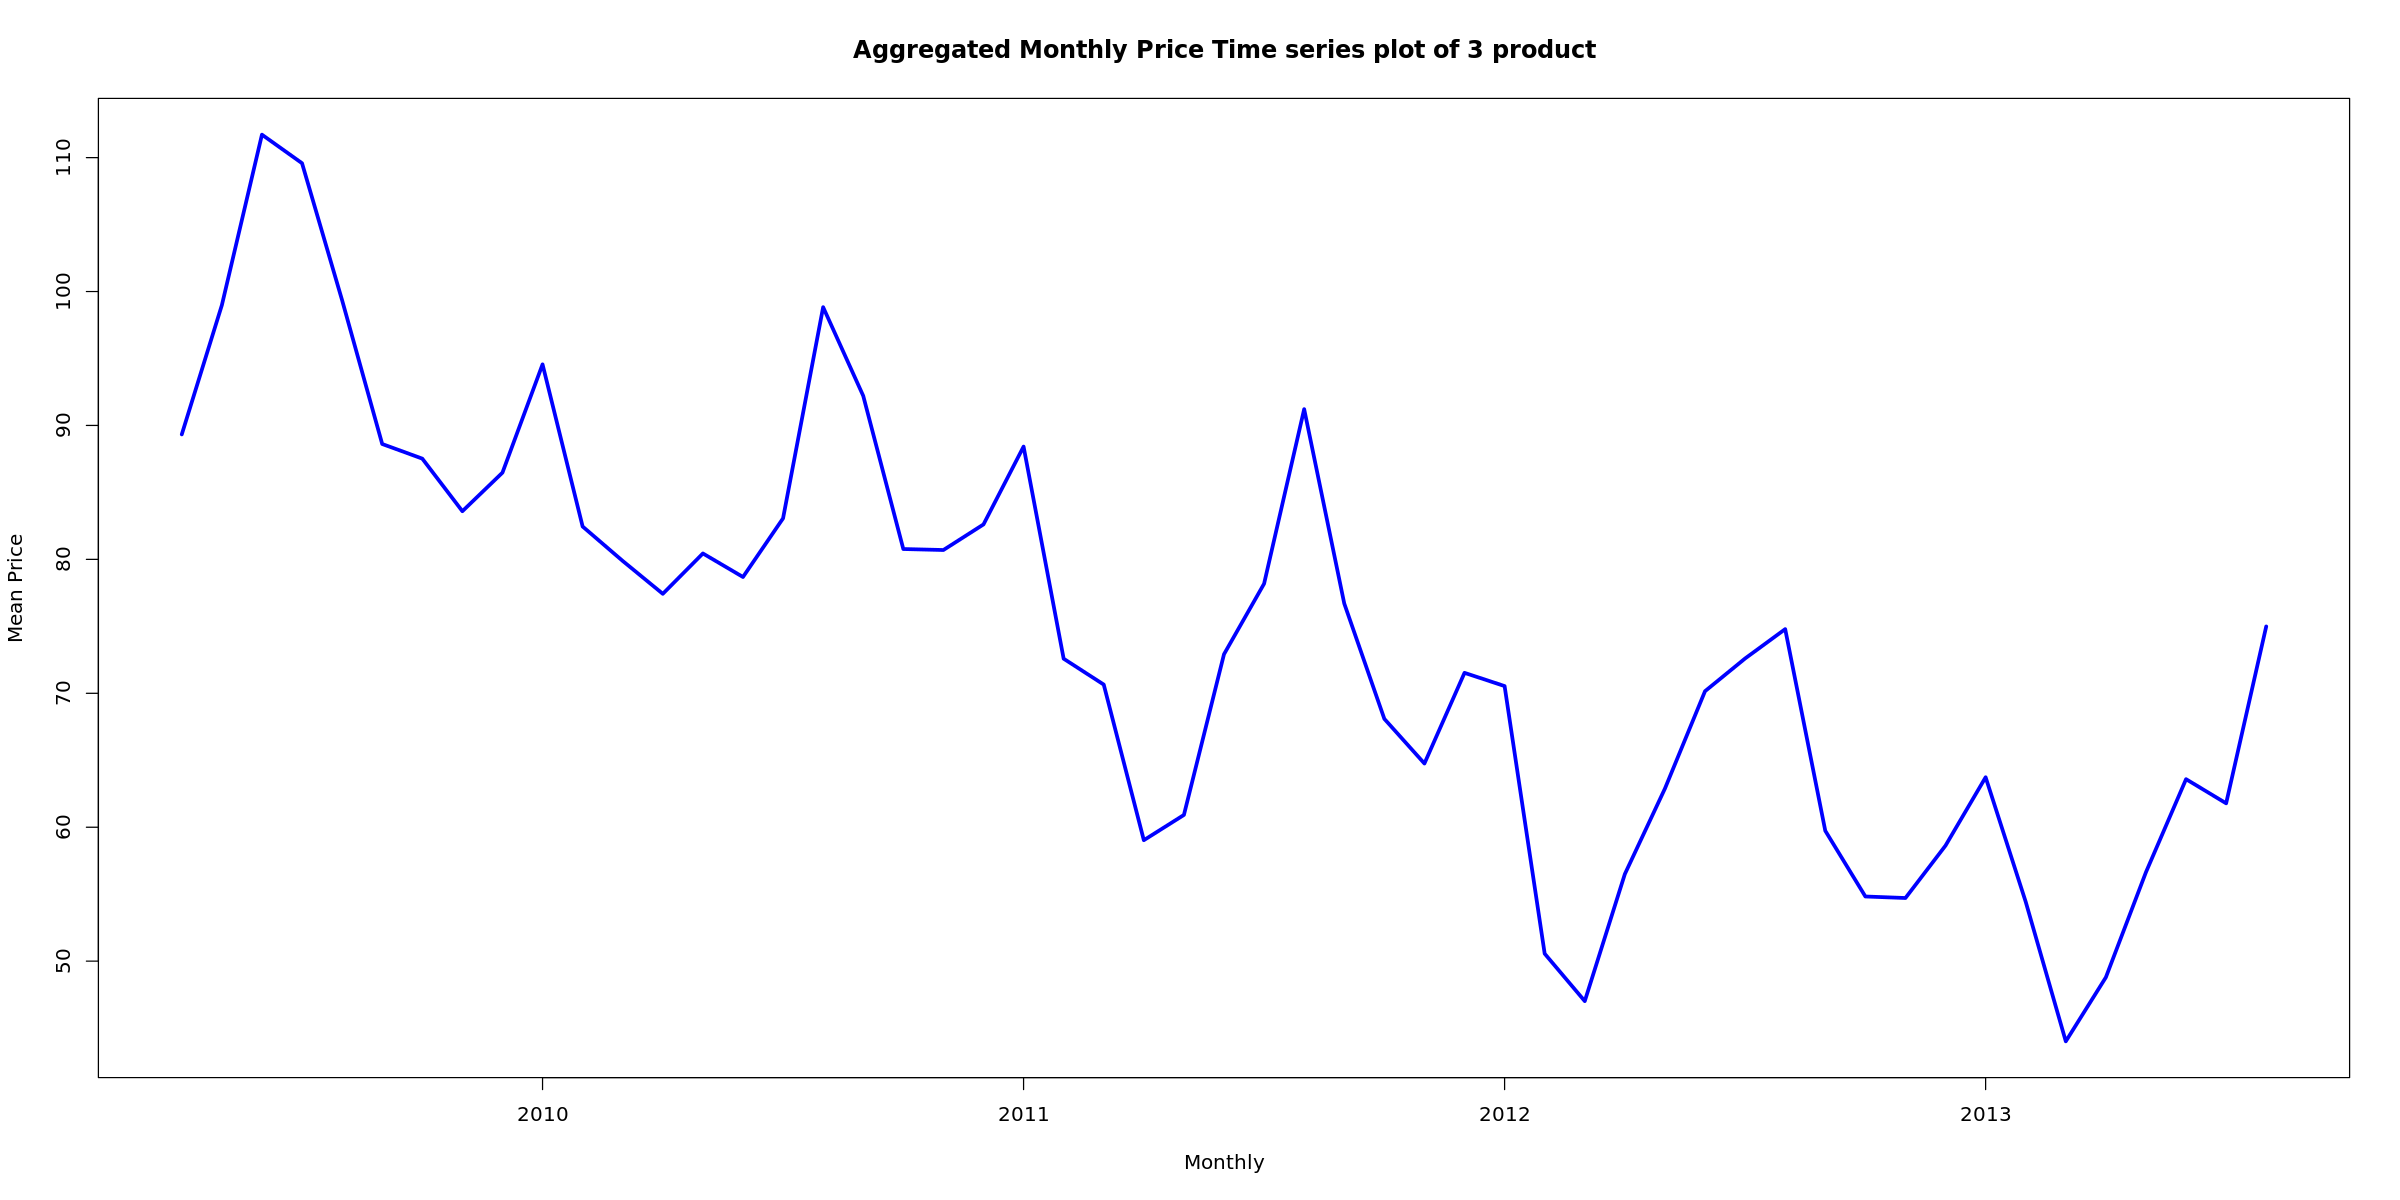

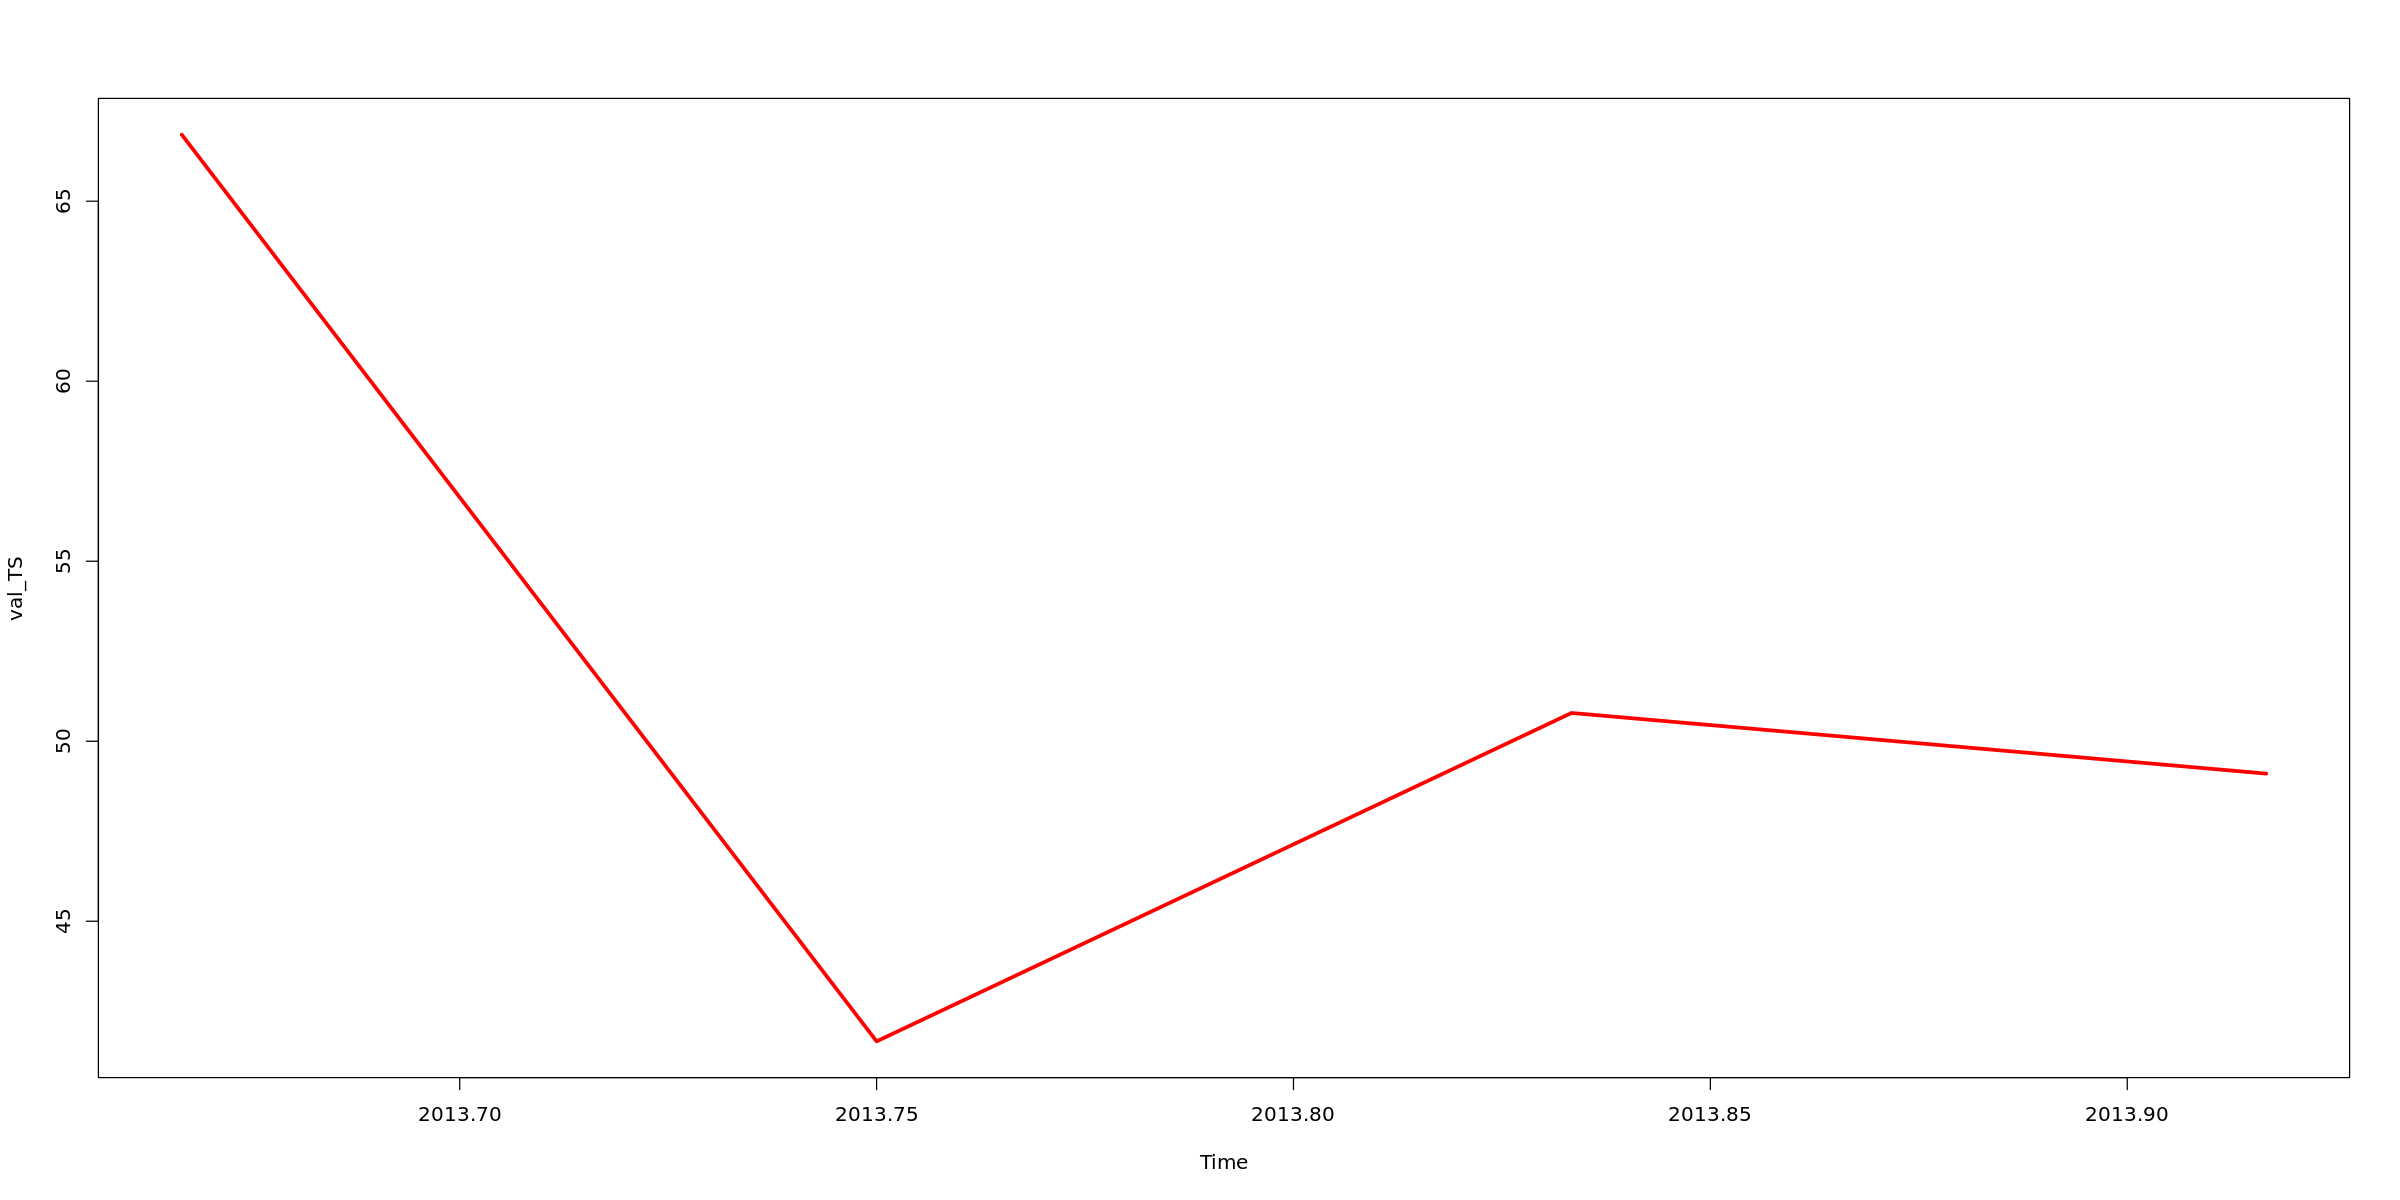

In [39]:
# Converting data into R time series object 
train_TS <- ts(train$MeanPrice, frequency = 12, start = c(2009, 4))
train_TS

val_TS <- ts(val$MeanPrice, frequency = 12, start = c(2013, 9))
#val_TS


# Visualize the time series Data
plot(train_TS, 
     type="l", lwd=3, col="blue", 
     xlab="Monthly", ylab="Mean Price",
     main="Aggregated Monthly Price Time series plot of 3 product")
plot(val_TS, col="red", lwd=3)

In [51]:
train_TS1 <- ts(train$MeanPrice, frequency = 12, start = c(2008, 9))

val_TS1<- ts(val$MeanPrice, frequency = 12, start = c(2013, 2))

In [52]:
train_TS1

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,,,,,,,,,89.33187,98.98226,111.71333,109.58000
2009,99.34645,88.61500,87.52210,83.59500,86.47677,94.56161,82.45250,79.88065,77.42767,80.44161,78.68367,83.06452
2010,98.83145,92.20900,80.77274,80.69867,82.61000,88.42161,72.58196,70.64968,59.03067,60.91677,72.91667,78.18194
2011,91.21645,76.70200,68.08935,64.75600,71.52661,70.53839,50.55517,47.01290,56.50133,62.88645,70.15700,72.60000
2012,74.79161,59.73300,54.82694,54.71333,58.62968,63.73032,54.42857,44.01097,48.79200,56.64129,63.58633,61.78355
2013,74.99113,,,,,,,,,,,


In [53]:
val_TS1

,Feb,Mar,Apr,May
2013,66.84800,41.66387,50.78450,49.10000


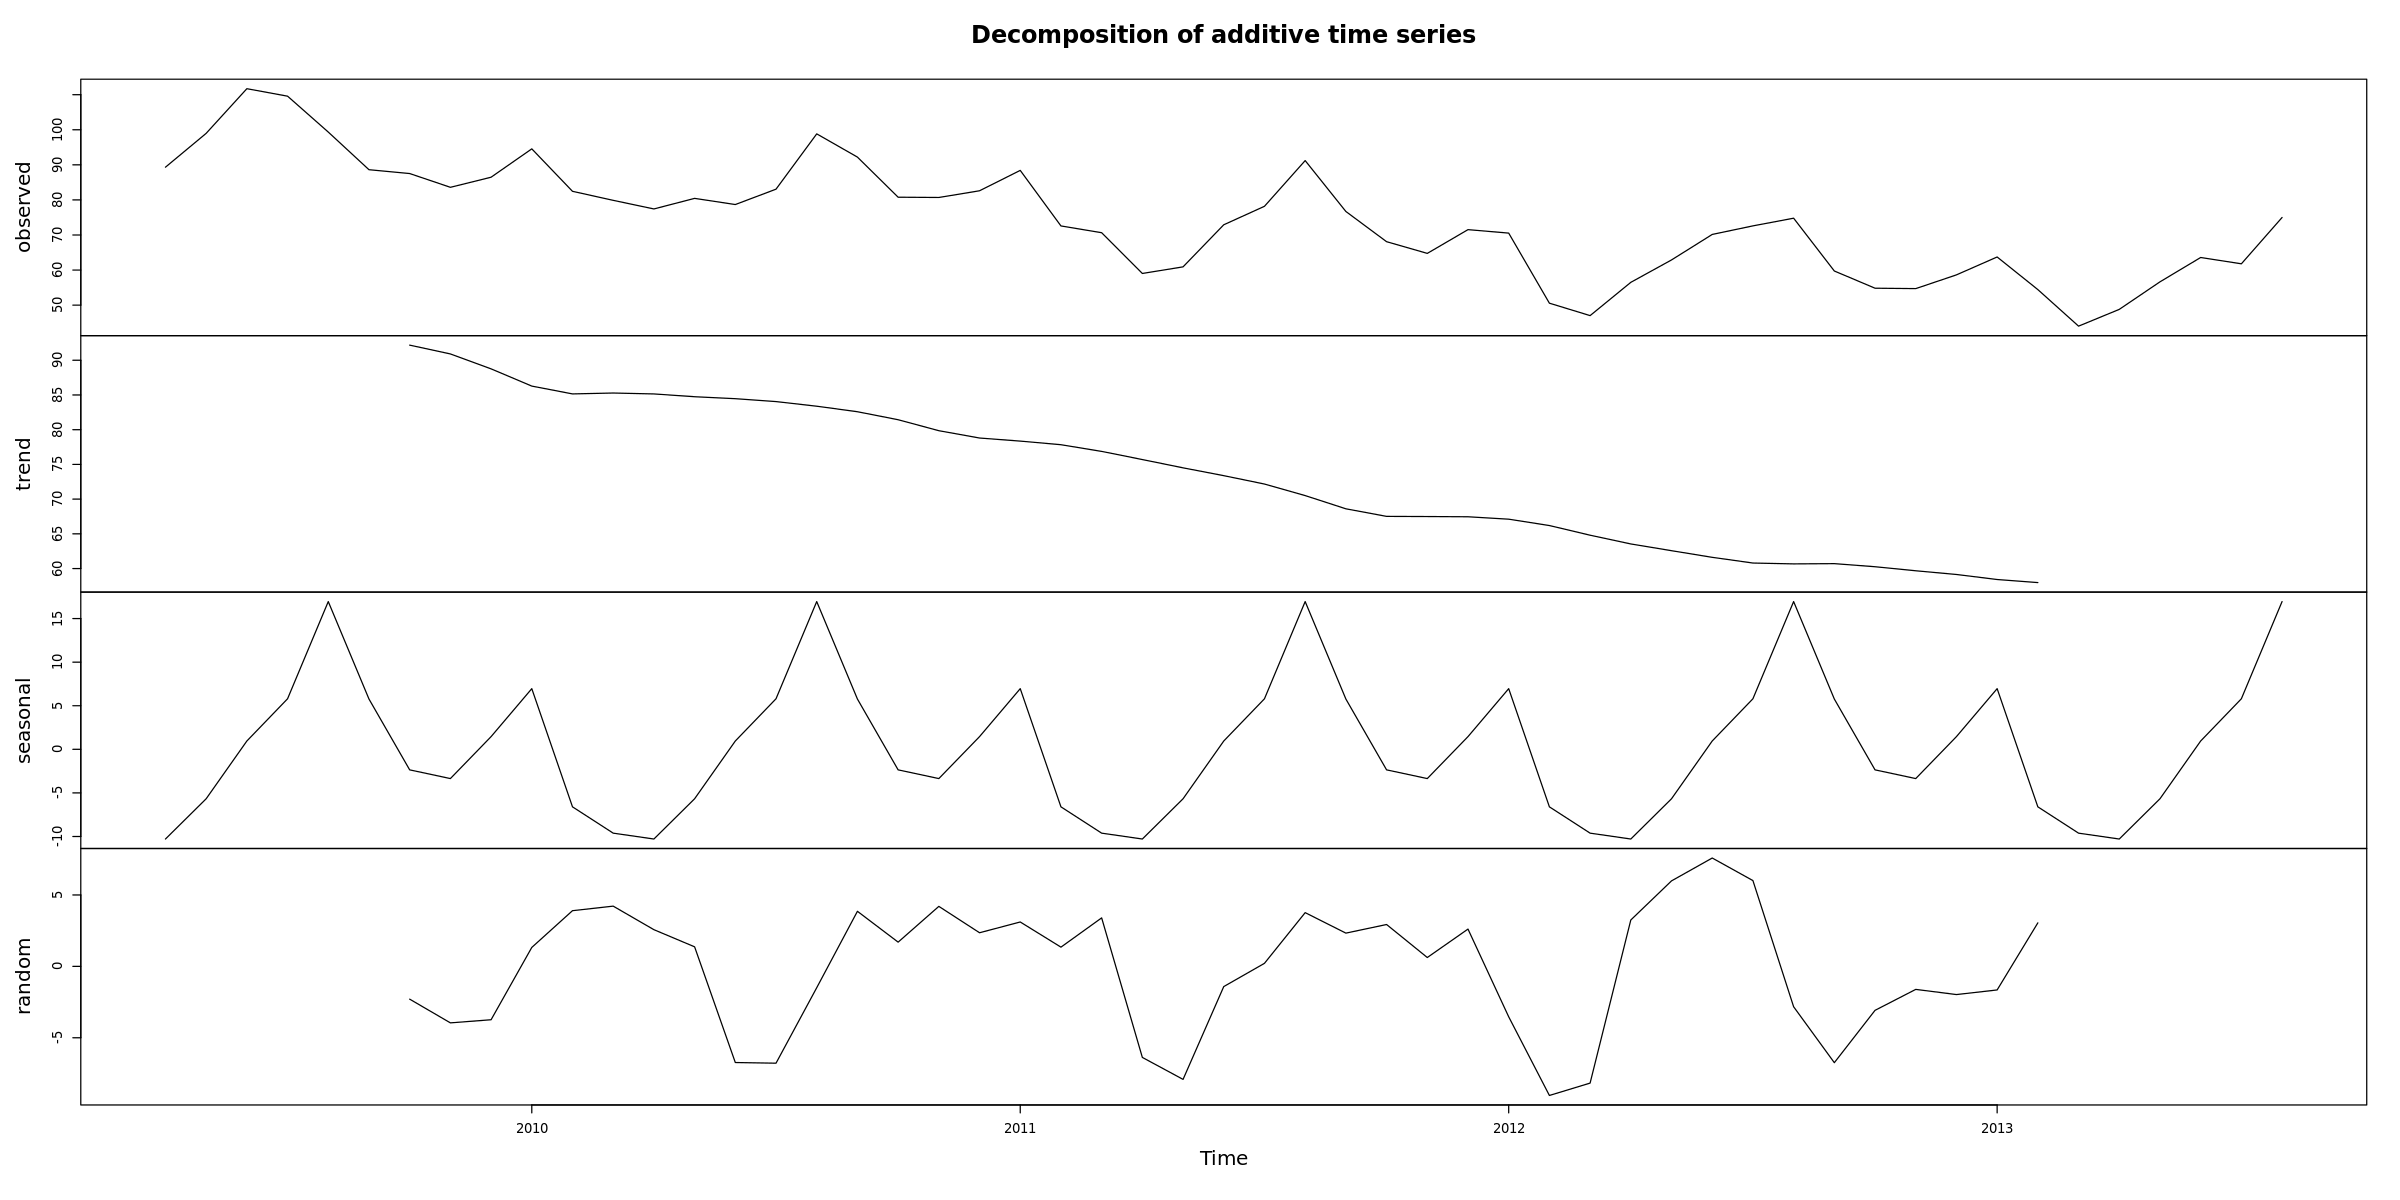

In [ ]:
plot(decompose(train_TS))